In [1]:
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer

In [2]:
df1 = pd.read_parquet('./data/sillok_finetune.parquet', engine='pyarrow')
df1.head()

,king,king_order,year,relative_year,month,entry_order,original_text,translated_text
0,태조,1,NaN,NaN,총서,1.0,"太祖康獻至仁啓運聖文神武大王, 姓李氏, 諱旦, 字君晋, 古諱成桂, 號松軒, 全州大姓也...",태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏...
1,태조,1,NaN,NaN,총서,2.0,"○明年乙卯, 散吉聞于元帝, 元爲立斡東千戶所, 給降金牌, 爲南京等處五千戶所, 首千戶、...","명년 을묘(1255)에 산길이 이 사실을 원(元)나라 황제에게 알리니, 원나라에서 ..."
2,태조,1,NaN,NaN,총서,3.0,"○斡東東南三十餘里, 有海島曰者考羅, 北連於陸。 穆祖築石城, 以放牛馬。","알동의 동남쪽 30여 리에 해도(海島)가 있는데, 자고라(者考羅)라고 한다. 북쪽으..."
3,태조,1,NaN,NaN,총서,4.0,"○憲宗八年, 受散吉令旨, 管領李春、文大純、趙奧、魯哥兒、卓靑、尙哉、光奕、張哥等八介百戶...","〈원나라〉 헌종(憲宗) 8년(1258)에 산길(散吉)의 영지(令旨)를 받아, 이춘(..."
4,태조,1,NaN,NaN,총서,5.0,"○世祖皇帝 中統二年辛酉六月, 尙書省給降本所行使銅印。",세조 황제(世祖皇帝) 중통(中統) 2년(1261) 신유 6월에 상서성(尙書省)에서 ...


In [3]:
df1['year'].value_counts()

year
1618.0    5235
1612.0    4061
1613.0    3720
1616.0    3440
1617.0    3260
          ... 
1607.0      54
1586.0      47
1571.0      43
1582.0      37
1928.0       7
Name: count, Length: 372, dtype: int64

In [4]:
df1['relative_year'].unique().astype(int)

/var/folders/l4/xcb152_d5v51k4kx19t42f0w0000gn/T/ipykernel_68822/1582849484.py:1: RuntimeWarning: invalid value encountered in cast
  df1['relative_year'].unique().astype(int)


array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18, 1418,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32, 1450, 1468, 1469,   33,   34,   35,   36,   37,   38,   39,
       1545, 1567,   40,   41, 1608, 1649, 1659, 1674,   42,   43,   44,
         45,   46, 1720, 1863, 1907])

In [5]:
df1['month'].unique()

array(['총서', '7월', '8월', '9월', '10월', '11월', '12월', '윤12월', '1월', '2월',
       '3월', '4월', '5월', '6월', '윤9월', '윤5월', '윤3월', '윤11월', '윤7월', '윤4월',
       '윤1월', '윤8월', '윤6월', '윤2월', '윤10월'], dtype=object)

In [6]:
len(df1)

308554

In [7]:
df1['original_text'].sample(1).iloc[0]

'○倭館火。 是月十六日夜, 倭館失火, 釜山僉使李延禎, 率土兵往救, 而風勢不順, 館宇又皆草蓋, 宴享大廳外, 一倂延燒, 倭船七隻及衣服器具, 蕩然無餘, 倭人赤身脫出。 上命本道, 以米二百石、木綿十同給之。 館倭受賜, 大喜過望, 稱以卽當報知島主, 申謝朝廷云。'

In [8]:
df1['original_text'].str.len().describe()

count    308554.000000
mean        215.600537
std        1404.764642
min           2.000000
25%          22.000000
50%          73.000000
75%         200.000000
max      361261.000000
Name: original_text, dtype: float64

In [9]:
df1['translated_text'].str.len().describe().astype(int)

count     308554
mean         516
std         3006
min            0
25%           52
50%          170
75%          510
max      1232042
Name: translated_text, dtype: int64

In [10]:
(df1['original_text'].str.len() > 5000).mean()

0.0016625939057668998

In [11]:
((df1['translated_text'].str.len() > 1000) & (df1['translated_text'].str.len() < 6000)).mean()

0.11937618698833916

따라서 `translated_text`의 길이가 1000보다 높으면서,6000보다 작은 샘플들 중에서 70%, 1000보다 작은 샘플들에서 30%를 추출하여 test set을 구성함.

In [12]:
np.corrcoef(df1['original_text'].str.len(), df1['translated_text'].str.len())

array([[1.        , 0.54443249],
       [0.54443249, 1.        ]])

In [13]:
df1[df1['original_text'].str.len() < 1000]['translated_text'].str.len().describe()

count    298465.000000
mean        357.075912
std         500.687014
min           0.000000
25%          50.000000
50%         159.000000
75%         454.000000
max       14683.000000
Name: translated_text, dtype: float64

In [14]:
df1[df1['original_text'].str.len() < 500]['translated_text'].str.len().describe()

count    280374.000000
mean        268.493751
std         325.297855
min           0.000000
25%          46.000000
50%         139.000000
75%         373.000000
max       10633.000000
Name: translated_text, dtype: float64

In [15]:
df1['translated_text'].str.len().describe().astype(int)

count     308554
mean         516
std         3006
min            0
25%           52
50%          170
75%          510
max      1232042
Name: translated_text, dtype: int64

<Axes: >

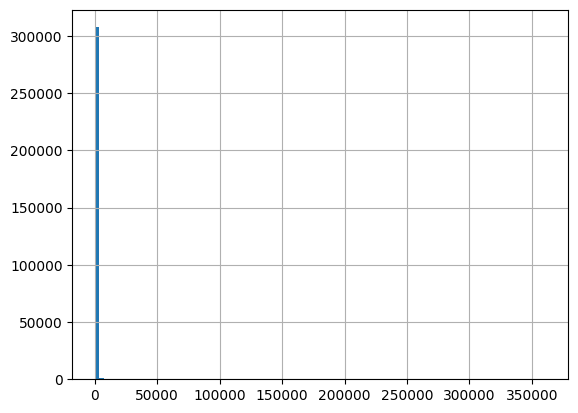

In [16]:
df1['original_text'].str.len().hist(bins=100)

<Axes: >

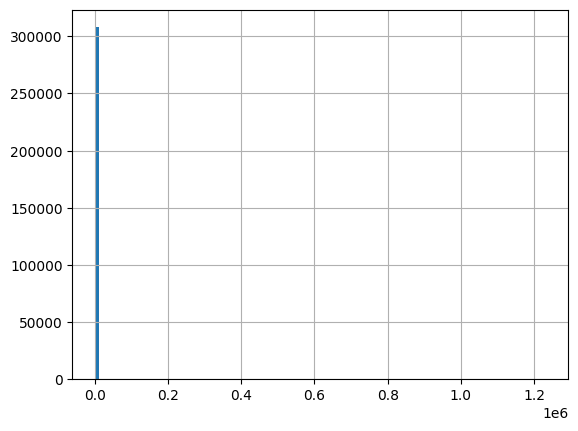

In [17]:
df1['translated_text'].str.len().hist(bins=100)

## Train / Test Set Hold

In [18]:
df1 = df1[df1['translated_text'].str.len() < 6000]
df1.head()

,king,king_order,year,relative_year,month,entry_order,original_text,translated_text
0,태조,1,NaN,NaN,총서,1.0,"太祖康獻至仁啓運聖文神武大王, 姓李氏, 諱旦, 字君晋, 古諱成桂, 號松軒, 全州大姓也...",태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏...
1,태조,1,NaN,NaN,총서,2.0,"○明年乙卯, 散吉聞于元帝, 元爲立斡東千戶所, 給降金牌, 爲南京等處五千戶所, 首千戶、...","명년 을묘(1255)에 산길이 이 사실을 원(元)나라 황제에게 알리니, 원나라에서 ..."
2,태조,1,NaN,NaN,총서,3.0,"○斡東東南三十餘里, 有海島曰者考羅, 北連於陸。 穆祖築石城, 以放牛馬。","알동의 동남쪽 30여 리에 해도(海島)가 있는데, 자고라(者考羅)라고 한다. 북쪽으..."
3,태조,1,NaN,NaN,총서,4.0,"○憲宗八年, 受散吉令旨, 管領李春、文大純、趙奧、魯哥兒、卓靑、尙哉、光奕、張哥等八介百戶...","〈원나라〉 헌종(憲宗) 8년(1258)에 산길(散吉)의 영지(令旨)를 받아, 이춘(..."
4,태조,1,NaN,NaN,총서,5.0,"○世祖皇帝 中統二年辛酉六月, 尙書省給降本所行使銅印。",세조 황제(世祖皇帝) 중통(中統) 2년(1261) 신유 6월에 상서성(尙書省)에서 ...


In [19]:
df1[['original_text', 'translated_text']]

,original_text,translated_text
0,"太祖康獻至仁啓運聖文神武大王, 姓李氏, 諱旦, 字君晋, 古諱成桂, 號松軒, 全州大姓也...",태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏...
1,"○明年乙卯, 散吉聞于元帝, 元爲立斡東千戶所, 給降金牌, 爲南京等處五千戶所, 首千戶、...","명년 을묘(1255)에 산길이 이 사실을 원(元)나라 황제에게 알리니, 원나라에서 ..."
2,"○斡東東南三十餘里, 有海島曰者考羅, 北連於陸。 穆祖築石城, 以放牛馬。","알동의 동남쪽 30여 리에 해도(海島)가 있는데, 자고라(者考羅)라고 한다. 북쪽으..."
3,"○憲宗八年, 受散吉令旨, 管領李春、文大純、趙奧、魯哥兒、卓靑、尙哉、光奕、張哥等八介百戶...","〈원나라〉 헌종(憲宗) 8년(1258)에 산길(散吉)의 영지(令旨)를 받아, 이춘(..."
4,"○世祖皇帝 中統二年辛酉六月, 尙書省給降本所行使銅印。",세조 황제(世祖皇帝) 중통(中統) 2년(1261) 신유 6월에 상서성(尙書省)에서 ...
...,...,...
308549,"三日。 申時, 裕陵啓欑宮。 仍行別奠。",신시(申時)에 유릉(裕陵)에서 찬궁(欑宮)을 열고 별전(別奠)을 행하였다.
308550,命金昇圭殯殿主監提擧差下。,김승규(金昇圭)를 빈전 주감 제거(殯殿主監提擧)에 차하(差下)하라고 명하였다.
308551,六日。 【陰曆戊辰五月十九日】 祔純宗于太廟。 純明孝皇后同祔。 御眞奉安于璿源殿。 【純宗...,【음력 무진(戊辰) 5월 19일】 태묘(太廟)에 순종(純宗)의 신주(神主)를 모시고...
308552,六日。 【陰曆戊辰五月十九日】 祔純宗于太廟。 純明孝皇后同祔。 御眞奉安于璿源殿。 【純宗...,【음력 무진(戊辰) 5월 19일】 태묘(太廟)에 순종(純宗)의 신주(神主)를 모시고...


In [20]:
f'Train Set Size : {int(len(df1) * 0.9)}, Test Set Size : {int(len(df1) * 0.1)}'

'Train Set Size : 275965, Test Set Size : 30662'

In [21]:
f'Train Set Size : {int(len(df1) * 0.9)}, Test Set Size : {int(len(df1) * 0.1)}'

'Train Set Size : 275965, Test Set Size : 30662'

In [22]:
group_factor = 5
df1['entry_order_grouped'] = df1['entry_order'] // group_factor
df1.head()

,king,king_order,year,relative_year,month,entry_order,original_text,translated_text,entry_order_grouped
0,태조,1,NaN,NaN,총서,1.0,"太祖康獻至仁啓運聖文神武大王, 姓李氏, 諱旦, 字君晋, 古諱成桂, 號松軒, 全州大姓也...",태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏...,0.0
1,태조,1,NaN,NaN,총서,2.0,"○明年乙卯, 散吉聞于元帝, 元爲立斡東千戶所, 給降金牌, 爲南京等處五千戶所, 首千戶、...","명년 을묘(1255)에 산길이 이 사실을 원(元)나라 황제에게 알리니, 원나라에서 ...",0.0
2,태조,1,NaN,NaN,총서,3.0,"○斡東東南三十餘里, 有海島曰者考羅, 北連於陸。 穆祖築石城, 以放牛馬。","알동의 동남쪽 30여 리에 해도(海島)가 있는데, 자고라(者考羅)라고 한다. 북쪽으...",0.0
3,태조,1,NaN,NaN,총서,4.0,"○憲宗八年, 受散吉令旨, 管領李春、文大純、趙奧、魯哥兒、卓靑、尙哉、光奕、張哥等八介百戶...","〈원나라〉 헌종(憲宗) 8년(1258)에 산길(散吉)의 영지(令旨)를 받아, 이춘(...",0.0
4,태조,1,NaN,NaN,총서,5.0,"○世祖皇帝 中統二年辛酉六月, 尙書省給降本所行使銅印。",세조 황제(世祖皇帝) 중통(中統) 2년(1261) 신유 6월에 상서성(尙書省)에서 ...,1.0


In [23]:
df1['entry_order_grouped'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., nan, 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
       51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.,
       64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76.,
       77., 78., 79., 80., 81., 82., 83.])

In [24]:
df1['entry_order_grouped'] = df1['entry_order_grouped'].fillna(-1)
df1.head()

,king,king_order,year,relative_year,month,entry_order,original_text,translated_text,entry_order_grouped
0,태조,1,NaN,NaN,총서,1.0,"太祖康獻至仁啓運聖文神武大王, 姓李氏, 諱旦, 字君晋, 古諱成桂, 號松軒, 全州大姓也...",태조 강헌 지인 계운 성문 신무 대왕(太祖康獻至仁啓運聖文神武大王)의 성은 이씨(李氏...,0.0
1,태조,1,NaN,NaN,총서,2.0,"○明年乙卯, 散吉聞于元帝, 元爲立斡東千戶所, 給降金牌, 爲南京等處五千戶所, 首千戶、...","명년 을묘(1255)에 산길이 이 사실을 원(元)나라 황제에게 알리니, 원나라에서 ...",0.0
2,태조,1,NaN,NaN,총서,3.0,"○斡東東南三十餘里, 有海島曰者考羅, 北連於陸。 穆祖築石城, 以放牛馬。","알동의 동남쪽 30여 리에 해도(海島)가 있는데, 자고라(者考羅)라고 한다. 북쪽으...",0.0
3,태조,1,NaN,NaN,총서,4.0,"○憲宗八年, 受散吉令旨, 管領李春、文大純、趙奧、魯哥兒、卓靑、尙哉、光奕、張哥等八介百戶...","〈원나라〉 헌종(憲宗) 8년(1258)에 산길(散吉)의 영지(令旨)를 받아, 이춘(...",0.0
4,태조,1,NaN,NaN,총서,5.0,"○世祖皇帝 中統二年辛酉六月, 尙書省給降本所行使銅印。",세조 황제(世祖皇帝) 중통(中統) 2년(1261) 신유 6월에 상서성(尙書省)에서 ...,1.0


In [25]:
long_form_df = df1.groupby(['king', 'year', 'month', 'entry_order_grouped'])[['original_text', 'translated_text']].aggregate({
    'original_text': lambda lt: ' '.join(lt),
    'translated_text': lambda lt: ' '.join(lt),
}).reset_index(drop=False)
long_form_df.head()

,king,year,month,entry_order_grouped,original_text,translated_text
0,경종,1720.0,10월,0.0,"○朔甲午/夜電。 ○以兪拓基爲吏曹佐郞。 ○行都堂錄, 選李箕鎭、申晳、申昉、金鎭商、李重協...",밤에 번개가 쳤다. 유척기(兪拓基)를 이조 좌랑(吏曹佐郞)으로 삼았다. (도당록(都...
1,경종,1720.0,10월,1.0,"○丙申/以柳重茂、朴彙登爲承旨。 ○戊戌/以李敏英、李翊漢爲承旨, 任泂爲掌令, 洪龍祚爲正...",유중무(柳重茂)·박휘등(朴彙登)을 승지(承旨)로 삼았다. 이민영(李敏英)·이익한(李...
2,경종,1720.0,10월,2.0,"○庚子/正言趙最壽上疏。 略曰:\n今日廷臣, 不知何故, 自生疑懼, 爲計日深, 凡所以操...","정언(正言) 조최수(趙最壽)가 소를 올렸는데, 대략 이르기를,\n""오늘날 조신(朝臣..."
3,경종,1720.0,10월,3.0,"○甲辰/摠護使李健命請對, 陳山陵坐向、水破、分金書刻及先朝虛右處, 所埋分金、坐向, 與傳...",총호사(摠護使) 이건명(李健命)이 청대(請對)하여 산릉(山陵)의 좌향(坐向)·수파(...
4,경종,1720.0,10월,4.0,"○辛亥/以兪命雄爲工曹判書。 命雄, 庸迷無所通曉, 夤緣倖會, 得致八座, 人皆笑之。 ○...",유명웅(兪命雄)을 공조 판서(工曹判書)로 삼았다. 유명웅은 인품이 용렬하고 식견(識...


In [26]:
long_form_df['original_text'].str.len().describe()

count    64623.000000
mean       846.684323
std        778.231056
min          4.000000
25%        327.000000
50%        635.000000
75%       1114.000000
max      24964.000000
Name: original_text, dtype: float64

<Axes: >

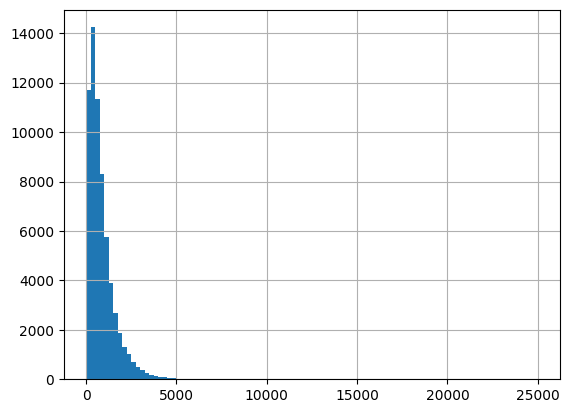

In [27]:
long_form_df['original_text'].str.len().hist(bins=100)

In [28]:
long_form_df['translated_text'].str.len().describe()

count    64623.000000
mean      2061.917723
std       1779.646696
min          8.000000
25%        779.000000
50%       1532.000000
75%       2820.500000
max      17555.000000
Name: translated_text, dtype: float64

In [29]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")

In [30]:
total_tokens = 0
total_strings = 0

for sentence in tqdm(long_form_df['translated_text']):
    tokens = tokenizer.tokenize(sentence)
    words = sentence.split()
    total_tokens += len(tokens)
    total_strings += len(sentence)

average_subwords_per_word = total_strings / total_tokens
print(f"Average subwords per word: {average_subwords_per_word:.2f}")

  0%|          | 0/64623 [00:00<?, ?it/s]

Average subwords per word: 1.36


In [31]:
total_tokens = 0
total_strings = 0

for sentence in tqdm(long_form_df['original_text']):
    tokens = tokenizer.tokenize(sentence)
    total_tokens += len(tokens)
    total_strings += len(sentence)

average_subwords_per_word = total_strings / total_tokens
print(f"Average subwords per word: {average_subwords_per_word:.2f}")

  0%|          | 0/64623 [00:00<?, ?it/s]

Average subwords per word: 0.98


<Axes: >

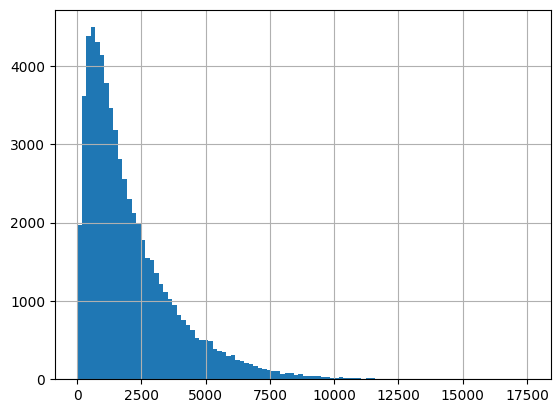

In [32]:
long_form_df['translated_text'].str.len().hist(bins=100)

In [33]:
len(long_form_df)

64623

In [34]:
long_form_df = long_form_df.drop(columns=['king', 'year', 'month', 'entry_order_grouped'])
long_form_df.head()

,original_text,translated_text
0,"○朔甲午/夜電。 ○以兪拓基爲吏曹佐郞。 ○行都堂錄, 選李箕鎭、申晳、申昉、金鎭商、李重協...",밤에 번개가 쳤다. 유척기(兪拓基)를 이조 좌랑(吏曹佐郞)으로 삼았다. (도당록(都...
1,"○丙申/以柳重茂、朴彙登爲承旨。 ○戊戌/以李敏英、李翊漢爲承旨, 任泂爲掌令, 洪龍祚爲正...",유중무(柳重茂)·박휘등(朴彙登)을 승지(承旨)로 삼았다. 이민영(李敏英)·이익한(李...
2,"○庚子/正言趙最壽上疏。 略曰:\n今日廷臣, 不知何故, 自生疑懼, 爲計日深, 凡所以操...","정언(正言) 조최수(趙最壽)가 소를 올렸는데, 대략 이르기를,\n""오늘날 조신(朝臣..."
3,"○甲辰/摠護使李健命請對, 陳山陵坐向、水破、分金書刻及先朝虛右處, 所埋分金、坐向, 與傳...",총호사(摠護使) 이건명(李健命)이 청대(請對)하여 산릉(山陵)의 좌향(坐向)·수파(...
4,"○辛亥/以兪命雄爲工曹判書。 命雄, 庸迷無所通曉, 夤緣倖會, 得致八座, 人皆笑之。 ○...",유명웅(兪命雄)을 공조 판서(工曹判書)로 삼았다. 유명웅은 인품이 용렬하고 식견(識...


In [35]:
original_text_max_length = 2_000
translated_text_max_length = 5_000
droping_query = ((long_form_df['original_text'].str.len() <= original_text_max_length)
                 & (long_form_df['translated_text'].str.len() <= translated_text_max_length))
long_form_df = long_form_df[droping_query]

print(f'Removed Fraction: {1 - droping_query.mean()}')

long_form_df

Removed Fraction: 0.09840149791869768


,original_text,translated_text
0,"○朔甲午/夜電。 ○以兪拓基爲吏曹佐郞。 ○行都堂錄, 選李箕鎭、申晳、申昉、金鎭商、李重協...",밤에 번개가 쳤다. 유척기(兪拓基)를 이조 좌랑(吏曹佐郞)으로 삼았다. (도당록(都...
1,"○丙申/以柳重茂、朴彙登爲承旨。 ○戊戌/以李敏英、李翊漢爲承旨, 任泂爲掌令, 洪龍祚爲正...",유중무(柳重茂)·박휘등(朴彙登)을 승지(承旨)로 삼았다. 이민영(李敏英)·이익한(李...
2,"○庚子/正言趙最壽上疏。 略曰:\n今日廷臣, 不知何故, 自生疑懼, 爲計日深, 凡所以操...","정언(正言) 조최수(趙最壽)가 소를 올렸는데, 대략 이르기를,\n""오늘날 조신(朝臣..."
3,"○甲辰/摠護使李健命請對, 陳山陵坐向、水破、分金書刻及先朝虛右處, 所埋分金、坐向, 與傳...",총호사(摠護使) 이건명(李健命)이 청대(請對)하여 산릉(山陵)의 좌향(坐向)·수파(...
4,"○辛亥/以兪命雄爲工曹判書。 命雄, 庸迷無所通曉, 夤緣倖會, 得致八座, 人皆笑之。 ○...",유명웅(兪命雄)을 공조 판서(工曹判書)로 삼았다. 유명웅은 인품이 용렬하고 식견(識...
...,...,...
64618,"○乙酉/右議政元斗杓呈告五度, 答曰: ""此何等時, 而卿之引入, 至於浹旬之久耶? 國事(...","우의정 원두표가 다섯 번째 정고(呈告)하니, 답하였다.\n""지금이 어떠한 때인데 경..."
64619,"○丁亥/忠洪道 西原縣佛像流汗。 ○憲府啓曰: ""全南監司徐必遠啓請: ‘刑曹罪囚趙義智, ...","충홍도 서원현(西原縣)에 있는 불상(佛像)에서 땀이 흘렀다. 헌부가 아뢰기를,\n""..."
64620,"○上召對玉堂講官, 講《心經》。 ○命賜金長生、金集同享書院額號曰遯巖。 李珥、李穡、金凈、...",상이 옥당의 강관을 소대하여 《심경》을 강하였다. 김장생(金長生)·김집(金集)을 함...
64621,"○庚寅/上召對玉堂講官, 講《心經》。 講訖, 僉知中樞沈光洙曰: ""近來災異, 極可驚懼,...",상이 옥당의 강관을 소대하여 《심경》을 강하였다. 강을 마치고 나서 첨지중추(僉知中...


<Axes: >

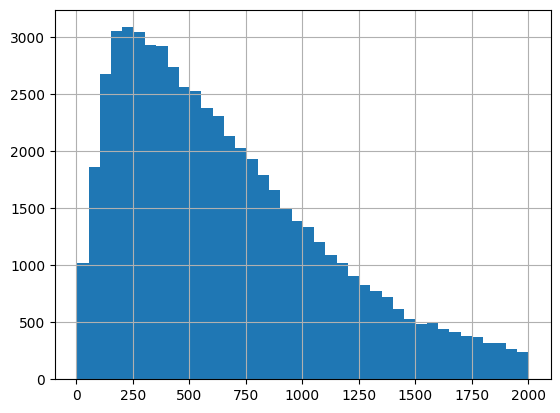

In [36]:
long_form_df['original_text'].str.len().hist(bins=40)

<Axes: >

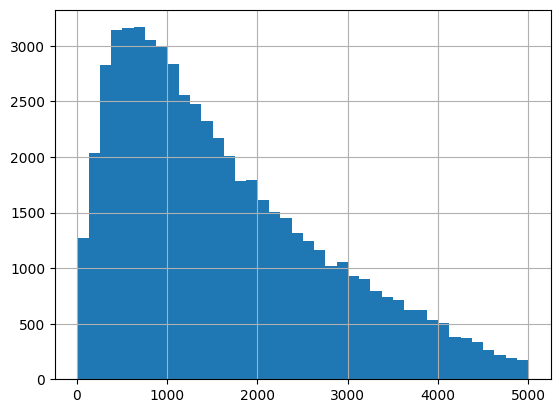

In [37]:
long_form_df['translated_text'].str.len().hist(bins=40)

In [38]:
train_df, test_df = train_test_split(long_form_df, test_size=0.1, random_state=42, shuffle=True)

In [39]:
len(train_df), len(test_df)

(52437, 5827)

In [40]:
train_df.to_parquet('./data/train.parquet')

In [41]:
test_df.to_parquet('./data/test.parquet')